# Data loading and Preprocessing

This script is for loading and preprocessing audio data for a deep learning-based audio compression project.
It includes functions for loading audio files, preprocessing them into suitable formats for training, and
splitting the data into training, validation, and test sets.

Instructions:
1. Ensure you have downloaded the dataset and set the correct paths for the training and testing directories.
2. Adjust the number of files to be loaded as per your requirements.
3. Install the required dependencies listed in the `requirements.txt` file.

Dependencies: os, numpy, librosa, random, sklearn, tensorflow, matplotlib, IPython, skimage, time, ipywidgets


In [1]:
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from skimage.metrics import structural_similarity as ssim
import time
import ipywidgets as widgets

# Helper function to load and preprocess audio data
def load_and_preprocess_data(directory, num_files, target_length=16000):
    data = []
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    selected_files = random.sample(files, num_files)
    
    for file in selected_files:
        file_path = os.path.join(directory, file)
        signal, _ = librosa.load(file_path, sr=None)
        if len(signal) < target_length:
            # Pad with zeros if the signal is shorter than target length
            pad_length = target_length - len(signal)
            signal = np.pad(signal, (0, pad_length), 'constant')
        elif len(signal) > target_length:
            # Truncate if the signal is longer than target length
            signal = signal[:target_length]
        data.append(signal)
    return np.array(data)

# Helper function to preprocess the dataset into TensorFlow format
def preprocess_dataset(data, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((data, data))  # Ensure (inputs, targets)
    dataset = dataset.map(lambda x, y: (tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)))
    dataset = dataset.map(lambda x, y: (tf.expand_dims(x, -1), tf.expand_dims(y, -1)))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Load and preprocess data
num_train_files = 23075
num_test_files = 1100

# Load training and testing data
clean_speech_train = load_and_preprocess_data('C:/Users/anand/Downloads/Dataset/clean_train', num_train_files)
clean_speech_test = load_and_preprocess_data('C:/Users/anand/Downloads/Dataset/clean_test', num_test_files)

# Split the training data into training and validation sets
clean_speech_train, clean_speech_val = train_test_split(clean_speech_train, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets
train_dataset = preprocess_dataset(clean_speech_train)
val_dataset = preprocess_dataset(clean_speech_val)
test_dataset = preprocess_dataset(clean_speech_test)

# Print the number of files loaded in each dataset
print(f"Training data files loaded: {len(clean_speech_train)}")
print(f"Validation data files loaded: {len(clean_speech_val)}")
print(f"Test data files loaded: {len(clean_speech_test)}")

# Print the shapes of the datasets
print("\nShapes of datasets:")
print(f"Training dataset shape: {clean_speech_train.shape}")
print(f"Validation dataset shape: {clean_speech_val.shape}")
print(f"Test dataset shape: {clean_speech_test.shape}")

print("\nData loading and preprocessing is complete.")

C:\Users\anand\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Training data files loaded: 18460
Validation data files loaded: 4615
Test data files loaded: 1100

Shapes of datasets:
Training dataset shape: (18460, 16000)
Validation dataset shape: (4615, 16000)
Test dataset shape: (1100, 16000)

Data loading and preprocessing is complete.


# Model Building 

This script defines a deep learning-based autoencoder model for audio compression using ResNet blocks in the encoder and decoder. The autoencoder compresses 1-second audio samples into a latent representation and then reconstructs the audio from this compressed representation.

The script consists of:
1. ResNet block definition
2. Encoder model definition
3. Decoder model definition
4. Autoencoder model definition
5. Building and compiling the autoencoder model
6. Displaying model summaries
7. Example input and output shapes

Ensure you have TensorFlow and other dependencies installed before running this script.

In [2]:
# Define the ResNet block
def resnet_block(inputs, filters, kernel_size, strides):
    # First convolutional layer
    x = tf.keras.layers.Conv1D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Second convolutional layer
    x = tf.keras.layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Shortcut connection
    shortcut = tf.keras.layers.Conv1D(filters, 1, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Define the encoder
def build_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial convolutional layer
    x = tf.keras.layers.Conv1D(64, 3, strides=2, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    
    # ResNet blocks
    for _ in range(4):
        x = resnet_block(x, 64, 3, 2)
    
    # LSTM layer and dense layer
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    encoder = tf.keras.Model(inputs, x, name='encoder')
    return encoder

# Define the decoder
def build_decoder(latent_dim, output_shape):
    inputs = tf.keras.Input(shape=(None, latent_dim))
    
    # Dense layer and LSTM layer
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    
    # Transposed convolutional layers
    for _ in range(4):
        x = tf.keras.layers.Conv1DTranspose(64, 3, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    
    # Final transposed convolutional layer
    x = tf.keras.layers.Conv1DTranspose(1, 3, strides=2, padding='same')(x)
    outputs = tf.keras.layers.Activation('tanh')(x)
    
    decoder = tf.keras.Model(inputs, outputs, name='decoder')
    return decoder

# Define the autoencoder
def build_autoencoder(encoder, decoder):
    inputs = encoder.input
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(inputs, decoded, name='autoencoder')
    return autoencoder

# Build and compile the autoencoder
input_shape = (16000, 1)  # Example input shape for 1 second of audio at 16kHz
latent_dim = 128
output_shape = (16000, 1)
encoder = build_encoder(input_shape)
decoder = build_decoder(latent_dim, output_shape)
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

# Print summaries
print("Encoder Summary:")
encoder.summary()

print("\nDecoder Summary:")
decoder.summary()

print("\nAutoencoder Summary:")
autoencoder.summary()

# Example input and output shapes
example_input = tf.random.normal((1, 16000, 1))  # Batch size of 1, input length of 16000, 1 channel
encoded_output = encoder(example_input)
decoded_output = decoder(encoded_output)

print("\nExample Input Shape:", example_input.shape)
print("Encoded Output Shape:", encoded_output.shape)
print("Decoded Output Shape:", decoded_output.shape)

print("\nModel building is complete.")

Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 16000, 1)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 8000, 64)          │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 8000, 64)          │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 4000, 64)          │          12,352 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 4000, 64)          │             256 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 4000, 64)          │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 4000, 64)          │          12,352 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 4000, 64)          │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 4000, 64)          │           4,160 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 4000, 64)          │               0 │ batch_normalization_1[0][… │
│                               │                           │                 │ conv1d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 4000, 64)          │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 2000, 64)          │          12,352 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 2000, 64)          │             256 │ conv1d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 2000, 64)          │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 2000, 64)          │          12,352 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 233,088 (910.50 KB)

 Trainable params: 232,064 (906.50 KB)

 Non-trainable params: 1,024 (4.00 KB)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, None, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, None, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, None, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, None, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, None, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, None, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_3 (Conv1DTranspose) │ (None, None, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, None, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_4 (Conv1DTranspose) │ (None, None, 1)             │             193 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, None, 1)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,009 (824.25 KB)

 Trainable params: 210,497 (822.25 KB)

 Non-trainable params: 512 (2.00 KB)


Autoencoder Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 500, 128)            │         233,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 16000, 1)            │         211,009 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 444,097 (1.69 MB)

 Trainable params: 442,561 (1.69 MB)

 Non-trainable params: 1,536 (6.00 KB)


Example Input Shape: (1, 16000, 1)
Encoded Output Shape: (1, 500, 128)
Decoded Output Shape: (1, 16000, 1)

Model building is complete.


# Model training 

This script continues from the data preprocessing phase and focuses on training the autoencoder model for audio compression. It includes:
1. Printing the shapes of the training, validation, and test datasets.
2. Setting up an early stopping callback to prevent overfitting.
3. Training the autoencoder model with the early stopping callback.
4. Printing the training history.
5. Plotting the training and validation loss over epochs.
6. Saving the trained model.
7. Displaying the final autoencoder model summary.

Ensure you have already run the data preprocessing script to prepare the datasets before executing this script.

Training data shape: (18460, 16000)
Validation data shape: (4615, 16000)
Test data shape: (1100, 16000)
Epoch 1/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 964s 823ms/step - loss: 0.0056 - val_loss: 6.9125e-04
Epoch 2/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 937s 812ms/step - loss: 4.1587e-04 - val_loss: 3.9219e-04
Epoch 3/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 936s 812ms/step - loss: 2.8305e-04 - val_loss: 2.8874e-04
Epoch 4/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 939s 814ms/step - loss: 2.3449e-04 - val_loss: 2.2959e-04
Epoch 5/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 941s 815ms/step - loss: 1.9341e-04 - val_loss: 1.9611e-04
Epoch 6/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 946s 820ms/step - loss: 1.6809e-04 - val_loss: 1.6110e-04
Epoch 7/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 946s 820ms/step - loss: 1.4251e-04 - val_loss: 1.7406e-04
Epoch 8/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 944s 818ms/step - loss: 1.2793e-04 - val_loss: 1.7779e-04
Epoch 9/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 945s 819ms/step - loss: 1.1426e-04 - val_loss: 1.8326e-04


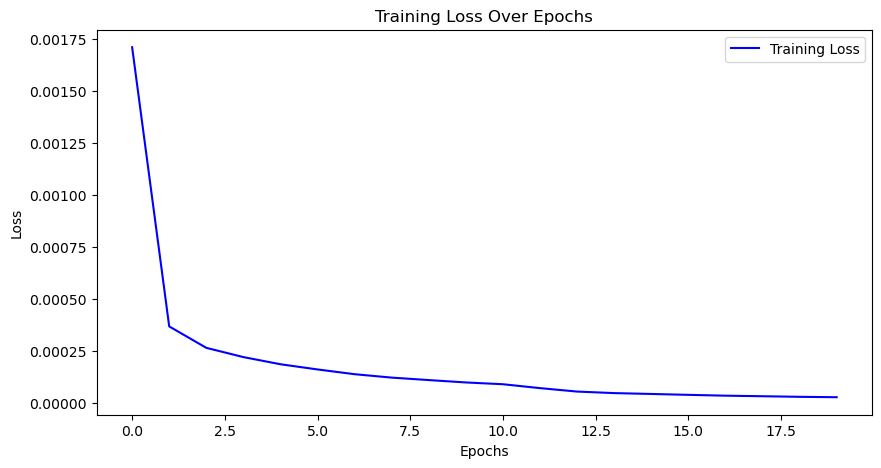

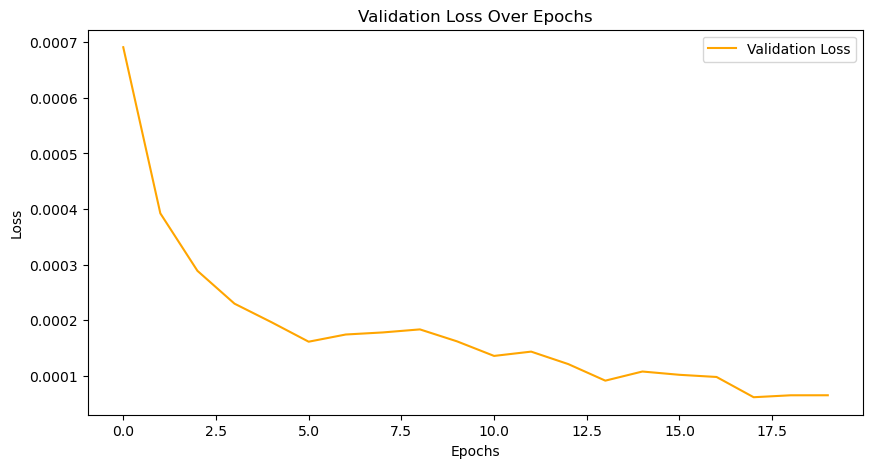

Saved model in path: E:/Mini Project/Dataset/Git/final_resnet_autoencoder_model.h5

Autoencoder Model Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 500, 128)            │         233,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 16000, 1)            │         211,009 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,221 (5.07 MB)

 Trainable params: 442,561 (1.69 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 885,124 (3.38 MB)

Model training is complete.


In [3]:
# Print the shapes of the datasets
print(f"Training data shape: {clean_speech_train.shape}")
print(f"Validation data shape: {clean_speech_val.shape}")
print(f"Test data shape: {clean_speech_test.shape}")

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(
    train_dataset,
    epochs=20,  # Adjusted to 20 for sufficient training
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Print training history
print("\nTraining history:")
print(history.history)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
model_path = 'E:/Mini Project/Dataset/Git/final_resnet_autoencoder_model.h5'
autoencoder.save(model_path)
print('Saved model in path: ' + model_path)

# Final model summary
print("\nAutoencoder Model Summary:")
autoencoder.summary()

print("Model training is complete.")